In [1]:
import ssl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
content_path = tf.keras.utils.get_file('golden_gate.jpeg', 'https://i.imgur.com/bs4loYm.jpeg')
style_path = tf.keras.utils.get_file('starry_night.jpeg', 'https://i.imgur.com/9ooB60I.jpg')

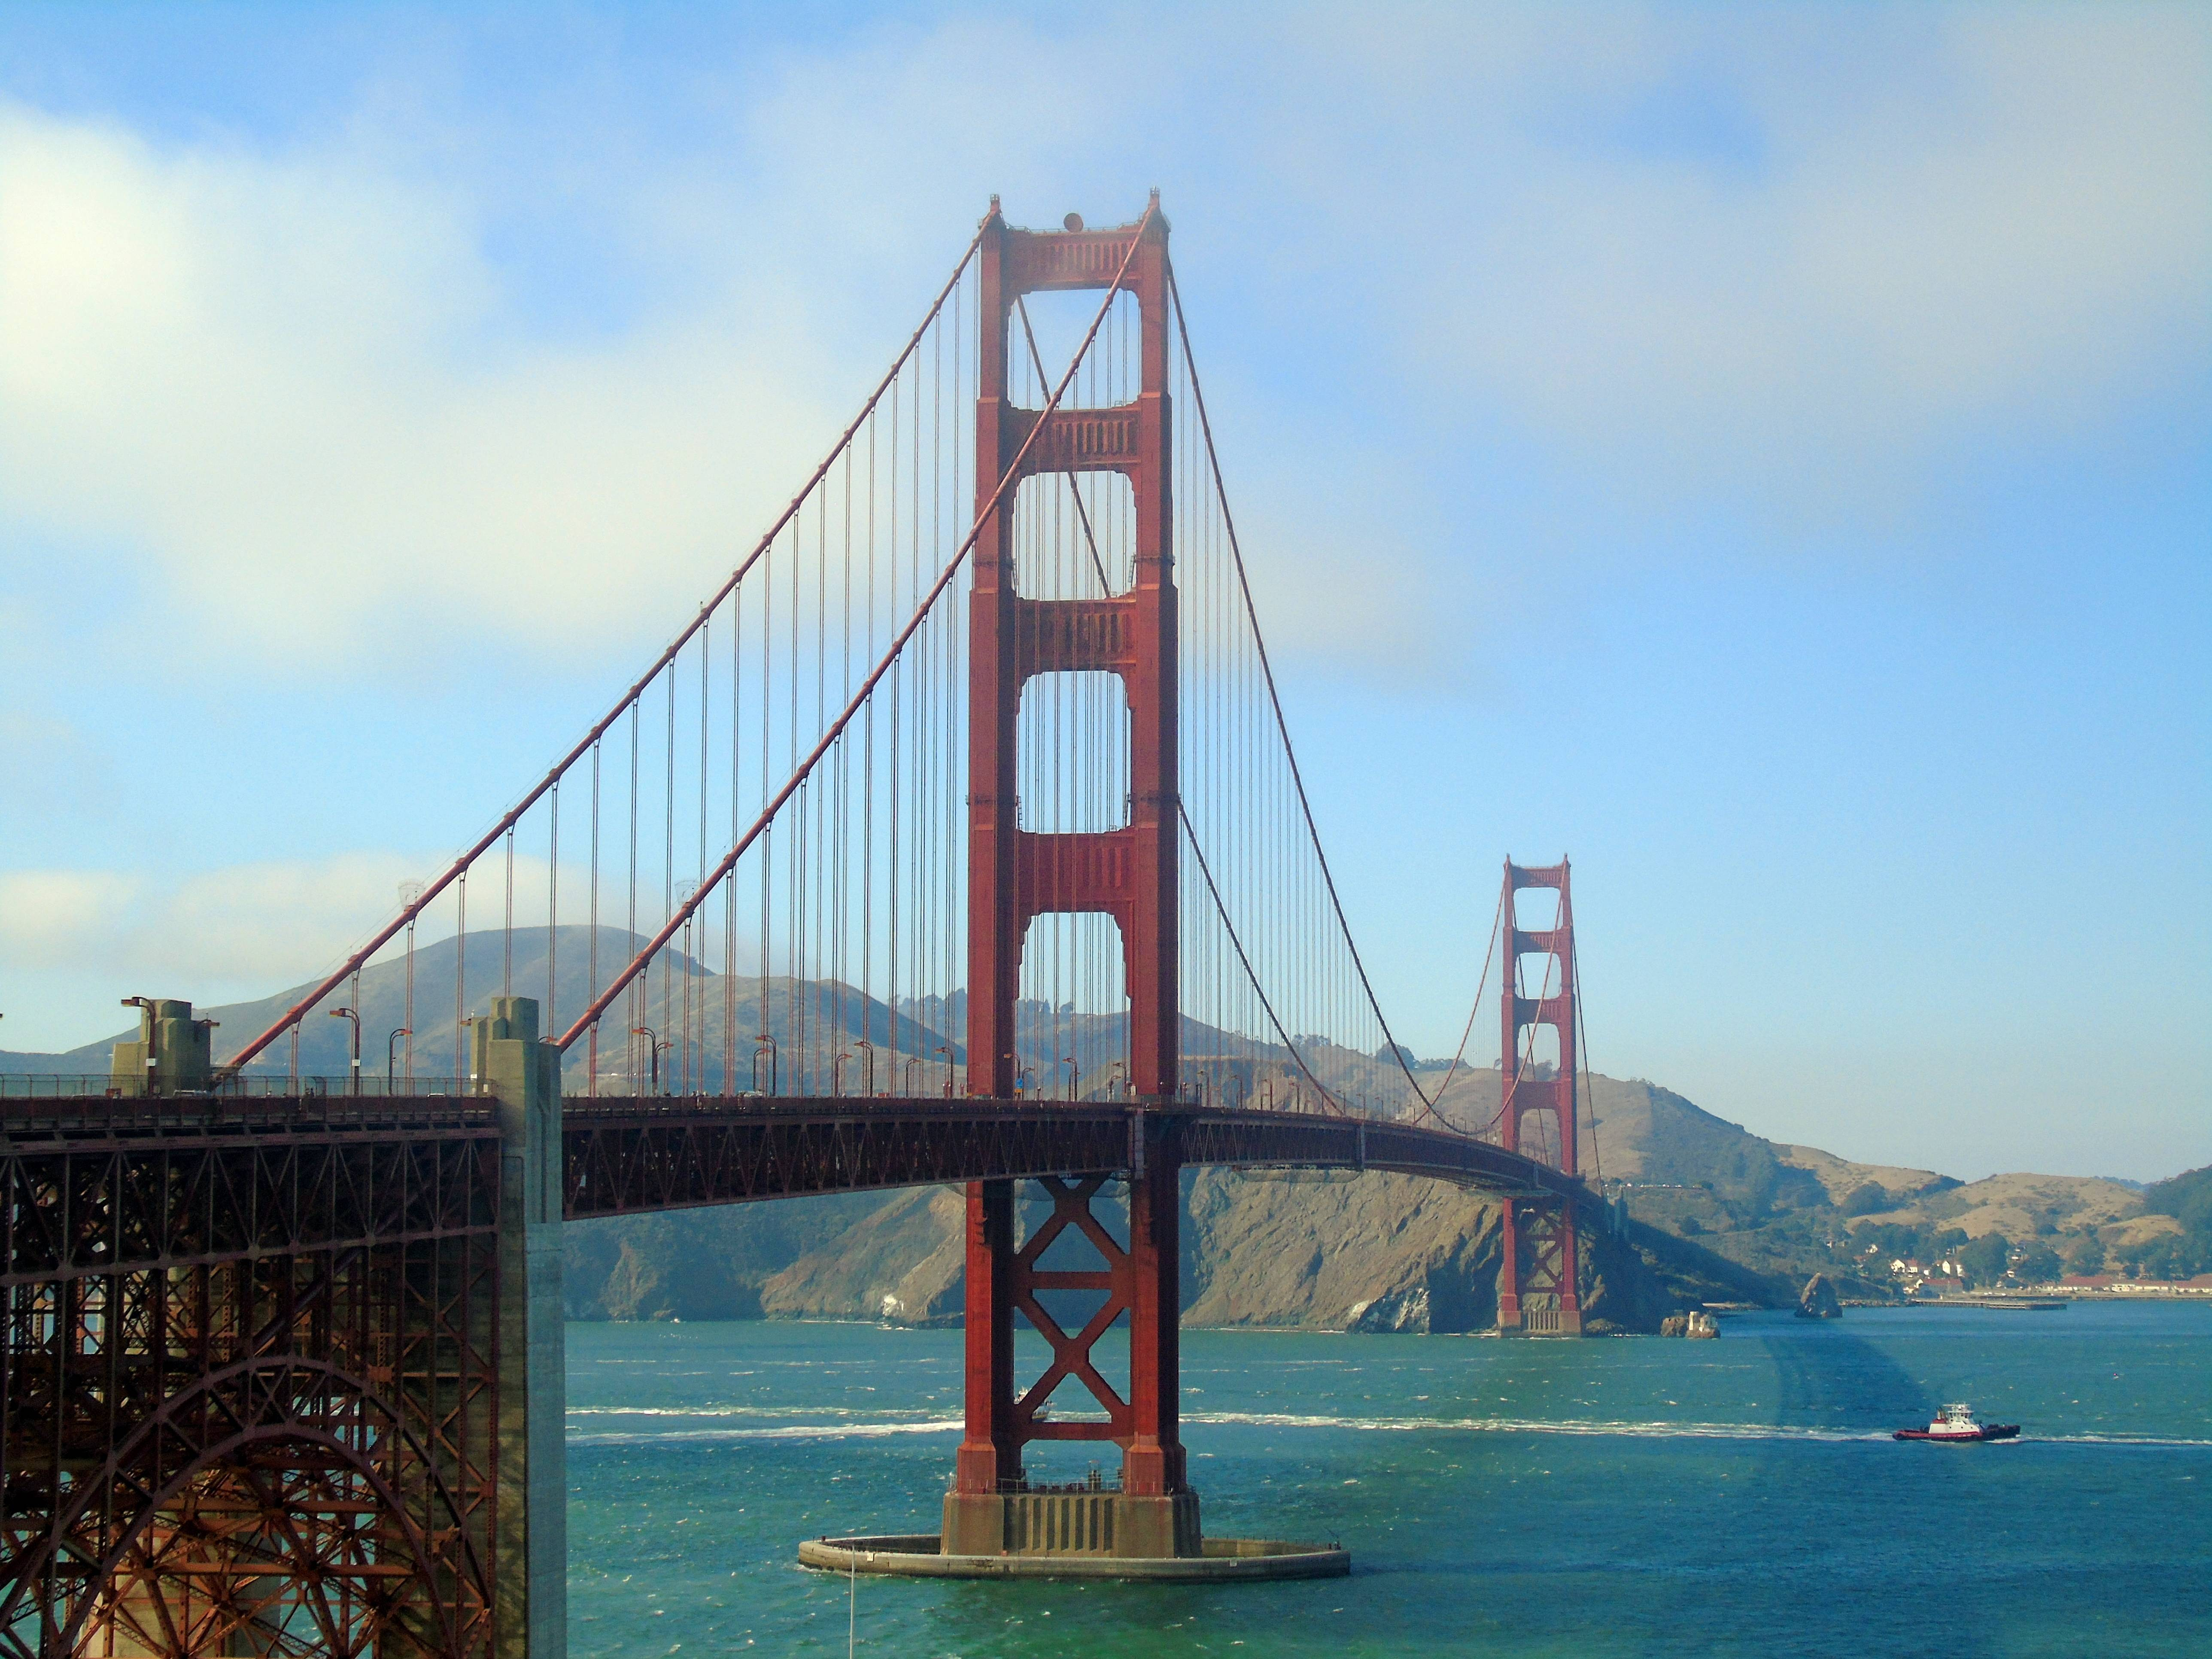

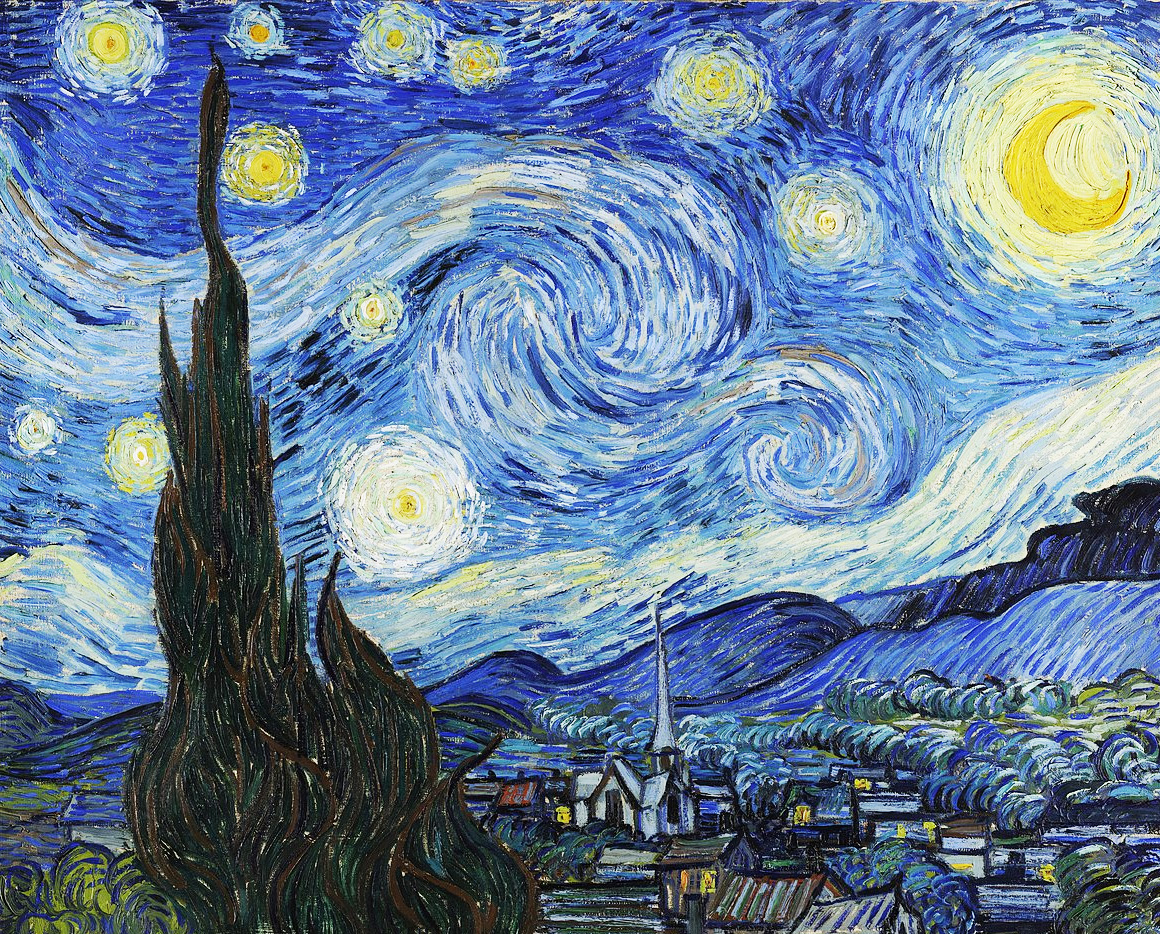

In [3]:
display.display(display.Image(content_path))
display.display(display.Image(style_path))

In [4]:
width, height = tf.keras.preprocessing.image.load_img(content_path).size
output_height = 350
output_width = int(output_height * width / height)

In [5]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(output_height,output_width))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    img = tf.convert_to_tensor(img)
    return img

In [33]:
model = VGG19(
    include_top=False,
    weights='imagenet'
)
# set training to False
model.trainable = False
# Print details of different layers
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [7]:
content_layer = 'block5_conv2'
content_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)

In [8]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
style_models = [tf.keras.Model(inputs=model.input,outputs=model.get_layer(layer).output) for layer in style_layers]

In [9]:
def content_loss(content, output):
    content_feature = content_model(content)
    output_feature = content_model(output)

    return tf.reduce_mean(tf.square(output_feature - content_feature))

In [10]:
def gram_matrix(x):
    channels = int(x.shape[-1])
    a = tf.reshape(x, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

style_layer_weight = 1. / len(style_models)
 
# style loss
def style_cost(style, output):
    total_cost = 0
 
    for model in style_models:
        style_feature = model(style)
        output_feature = model(output)
        A = gram_matrix(style_feature)
        G = gram_matrix(output_feature)

        layer_cost = tf.reduce_mean(tf.square(G - A))
        total_cost += style_layer_weight * layer_cost
 
    return total_cost

In [11]:
# training function
generated_images = []

# Weights of the different loss components
style_weight=1e-2
content_weight=1e4
total_variation_weight=30

def training_loop(content_path, style_path, iterations=60):
	# load content and style images from their respective path
	content = preprocess_image(content_path)
	style = preprocess_image(style_path)
	combination = tf.Variable(content, dtype=tf.float32)

	opt = tf.keras.optimizers.Adam(learning_rate=8)

	best_cost = float("inf")
	best_image = None

	for i in range(iterations):

		with tf.GradientTape() as tape:
			L_content = content_loss(content, combination)
			L_style = style_cost(style, combination)
			L_total = content_weight * L_content + style_weight * L_style
			L_total += total_variation_weight * tf.image.total_variation(combination)

		grads = tape.gradient(L_total, combination)
		opt.apply_gradients([(grads, combination)])

		if L_total < best_cost:
			best_cost = L_total
			best_image = combination.numpy()
			
		print("Iteration: %d: Total Loss = %.2f" % (i, L_total))
		generated_images.append(combination.numpy())

	return best_image

In [12]:
final_img = training_loop(content_path, style_path)

Iteration: 0: Total Loss = 1034152896.00
Iteration: 1: Total Loss = 778892480.00
Iteration: 2: Total Loss = 614240704.00
Iteration: 3: Total Loss = 578628480.00
Iteration: 4: Total Loss = 578610240.00
Iteration: 5: Total Loss = 568074752.00
Iteration: 6: Total Loss = 546022016.00
Iteration: 7: Total Loss = 529373248.00
Iteration: 8: Total Loss = 516607968.00
Iteration: 9: Total Loss = 503196704.00
Iteration: 10: Total Loss = 486849120.00
Iteration: 11: Total Loss = 470590592.00
Iteration: 12: Total Loss = 456351776.00
Iteration: 13: Total Loss = 442521984.00
Iteration: 14: Total Loss = 428472704.00
Iteration: 15: Total Loss = 414420256.00
Iteration: 16: Total Loss = 401438464.00
Iteration: 17: Total Loss = 389138912.00
Iteration: 18: Total Loss = 377579104.00
Iteration: 19: Total Loss = 366910368.00
Iteration: 20: Total Loss = 356944448.00
Iteration: 21: Total Loss = 347881024.00
Iteration: 22: Total Loss = 339598048.00
Iteration: 23: Total Loss = 331955648.00
Iteration: 24: Total Loss

In [13]:
def reconstruct_image(image):
    img = image.copy()
    # perform the inverse of the pre processing step
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # convert RGB to BGR
    img = img[:, :, ::-1]
 
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [14]:
def display_image(image):
    # remove one dimension if image has 4 dimension
    if len(image.shape) == 4:
        image = np.squeeze(image, axis=0)
 
    img = reconstruct_image(image)
 
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

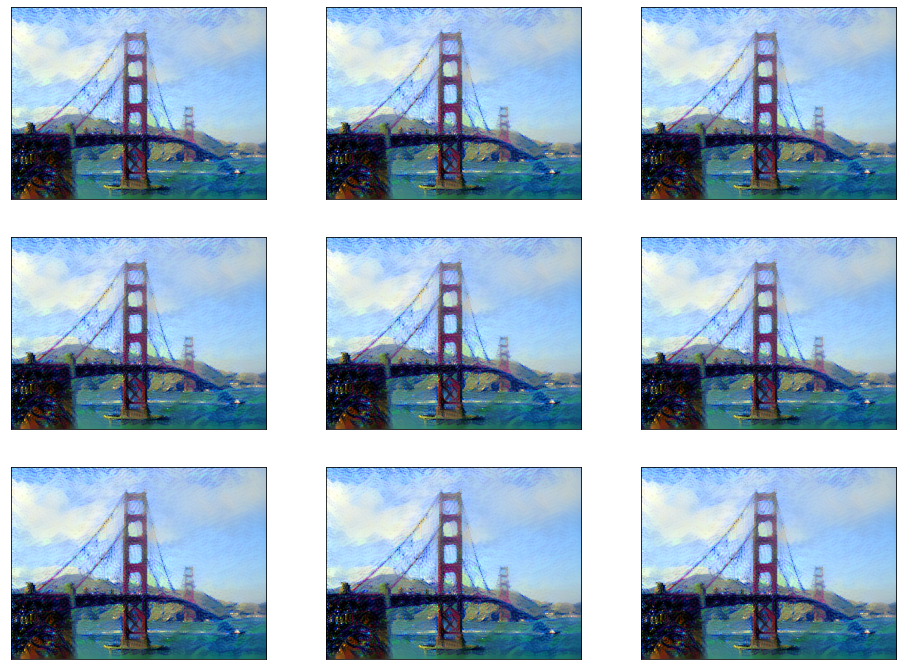

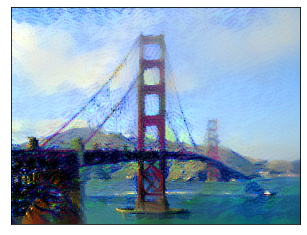

In [32]:
# code to display best generated image and last 10 intermediate results
plt.figure(figsize=(16, 12))
 
for i in range(9):
    plt.subplot(3, 3, i + 1)
    display_image(generated_images[i+39]) # [i+39]
plt.show()
 
# plot best result
display_image(final_img)